### Second step: DATA AUGMENTATION
Data augmentation is a technique for mitigation overfitting ***in computer vision***. It consists on generating more training data from existing training examples, by *augmenting* the samples via a number of transformations that yield believable-looking images. Like this, at training time, the model never sees the *exact* same picture twice.

This can be done by configuring a number of random transformations on the images read by the ```ImageDataGenerator```:
- ```rotation_range```: rotate pictures
- ```width_shift``` and ```height_shift```: translate picture, vertically or horizontally
- ```shear_range```: shearing transformation
- ```zoom_range```: zooming inside pictures
- ```horizontal_flip```: flipping half the images horizontally
- ```fill_mode```: the strategy used for filling in neawly created pixels (after rotation or a width/height shift)


In [1]:
# Paths to the data
import os

base_dir = '/tf/data'

# Directories for training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


#Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')


# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directory with test cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')

# Directory with test dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [2]:
# Use ImageDataGenerator to perform Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

# Define de model to train
from keras import layers
from keras import models
from tensorflow.keras import optimizers

# To plot the results (training and validation loss and accuracy)
import matplotlib.pyplot as plt

In [3]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

To see the augmented images (Image transformations require SciPy)

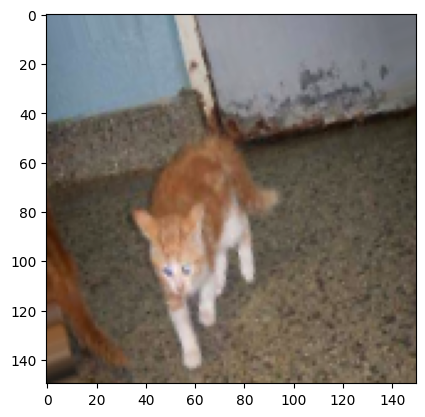

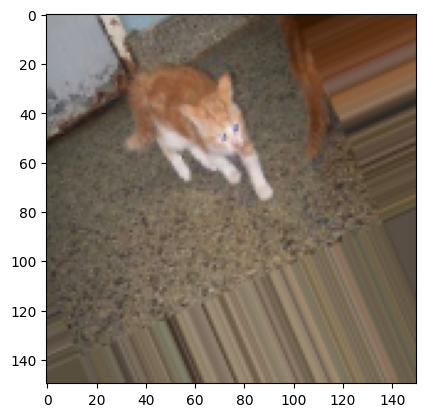

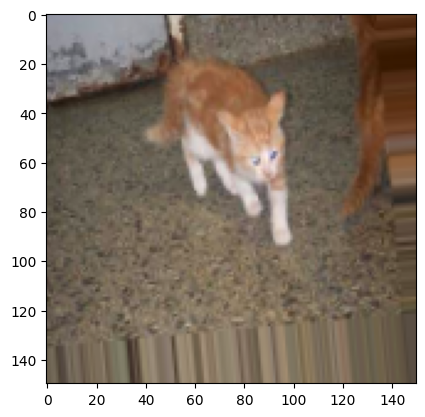

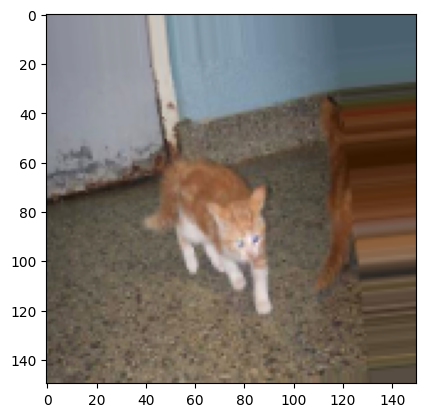

In [4]:
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

img_path = fnames[6]  # choose one image to augment

img = image.load_img(img_path, target_size=(150, 150))  # reads image and resizes

x = image.img_to_array(img)  # to numpy array (150, 150, 3)

x = x.reshape((1,) + x.shape)  # (1, 150, 150, 3)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

We can see we can only *remix **existing** information*. So this may not be enough to completely get rif of overfitting.

Add a ```Dropout``` layer, right before densely connected classifier:

In [12]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
            input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(learning_rate=1e-4),
            metrics=['acc'])

Train with data augmentation generators and dropout:

In [30]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(150, 150),
                batch_size=32,#20,
                class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                    validation_dir,
                    target_size=(150, 150),
                    batch_size=32,#20,
                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


We know that the ```train_generator``` found 2000 images. It's ```batch_size``` is 20. When we fit the ```model``` to the ```train_generator```, the ```steps_per_epoch``` **CAN'T** be higher than ```images/batch_size``` (2000/20=100), or the training will be interrupted saying:
>> WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 10000 batches). You may need to use the repeat() function when building your dataset.

Same for the ```validation_generator```. It found 1000 images, so the ```validation_steps``` **CAN'T** be higher than ```images/batch_size```, in this case, 1000/20=50.

In [33]:
history = model.fit(
        train_generator,
        steps_per_epoch=62,#100,    # train_generator: Found 2000 images => images/batch_size = steps_per_epoch => 2000/20 = 100
        epochs=100,
        validation_data=validation_generator,
        validation_steps=31)    # validation_generator: Found 1000 images => images/batch_size = validation_steps => 1000/20 = 50

Epoch 1/100
62/62 [==============================] - 9s 142ms/step - loss: 0.6433 - acc: 0.6174 - val_loss: 0.6110 - val_acc: 0.6472
Epoch 2/100
62/62 [==============================] - 9s 141ms/step - loss: 0.6306 - acc: 0.6397 - val_loss: 0.6279 - val_acc: 0.6179
Epoch 3/100
62/62 [==============================] - 9s 140ms/step - loss: 0.6193 - acc: 0.6484 - val_loss: 0.5943 - val_acc: 0.6845
Epoch 4/100
62/62 [==============================] - 9s 141ms/step - loss: 0.6101 - acc: 0.6702 - val_loss: 0.5879 - val_acc: 0.6835
Epoch 5/100
62/62 [==============================] - 9s 140ms/step - loss: 0.5957 - acc: 0.6819 - val_loss: 0.5659 - val_acc: 0.7077
Epoch 6/100
62/62 [==============================] - 9s 140ms/step - loss: 0.5987 - acc: 0.6758 - val_loss: 0.5883 - val_acc: 0.6774
Epoch 7/100
62/62 [==============================] - 9s 141ms/step - loss: 0.5891 - acc: 0.6723 - val_loss: 0.5707 - val_acc: 0.7026
Epoch 8/100
62/62 [==============================] - 9s 140ms/step - 

Save model:

In [11]:
model.save('/tf/data/saved-models/cats_and_dogs_small_2.h5')

Show results:

In [12]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

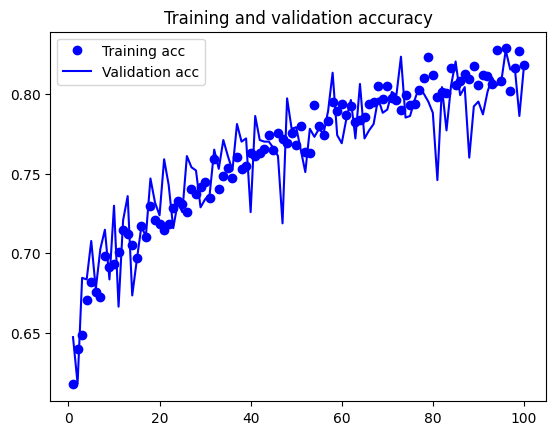

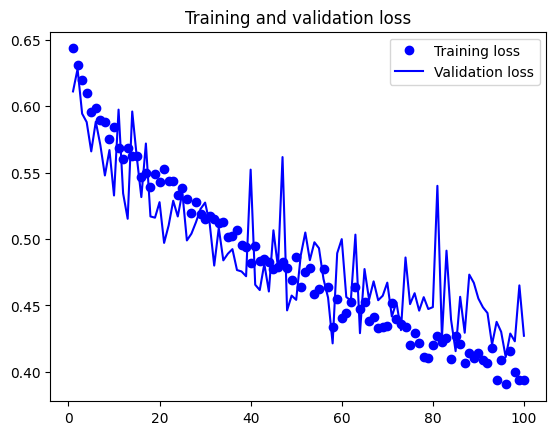

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()